# <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> EE 046202 - Technion - Unsupervised Learning & Data Analysis
---

#### <a href="https://taldatech.github.io">Tal Daniel</a>

## Tutorial 06 - Dimensionality Reduction - t-SNE
---

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Motivation and Introduction](#-Motivation-&-Introduction)
* [Stochastic Neighbor Embedding (SNE)](#-Stochstic-Neighbor-Embedding-(SNE))
* [t-Distributed Stochastic Neighbor Embedding (t-SNE)](#-t-Distributed-Stochastic-Neighbor-Embedding-(t-SNE))
    * [Symetric SNE](#-Symmetric-SNE)
    * [The Crowding Problem](#-The-Crowding-Problem)
    * [Student t-distribution](#-Student-t-Distribution---Mismatched-Tails-can-Compensate-for-Mismatched-Dimensionalities)
    * [Algorithm and Optimization](#-t-SNE-Optimization-&-Algorithm)
    * [Weaknesses](#-t-SNE-Weaknesses)
* [Examples](#-Example---The-Wisconsin-Breast-Cancer-Dataset)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import t
%matplotlib notebook

### <img src="https://img.icons8.com/cotton/50/000000/party-baloons.png" style="height:50px;display:inline"> Motivation & Introduction
---
* We want to have a dimensionality reduction method that may help us understand the data, and there is no better way to "explain" data than seeing it visually!
* **t-SNE** is a method to visualize *high-dimensional* data, which is easier to **optimize** than many other methods.
* One of its most important traits is that it mitigates **the crowding problem** which we will discuss, but many other dimensionality reduction algorithms suffer from.
    * In short, it is the tendency of dimensionality reduction algorithms to crowd points together in the center of the map.

* It looks really (!) good. Here, have a look at the result on the MNIST dataset (digits, 0-9): <img src="./assets/tut_xx_tsne_mnist.png" style="height:350px">

* The goal of dimensionality reduction is to **preserve as much of the significant structure of the high-dimensional data as possible in the low-dimensional map**.
    * For example, recall that **PCA** is a *linear* method that focuses on keeping the low-dimensional representations of dissimilar points far apart. It is very common to *chain* together PCA and t-SNE to achieve good results (first perform PCA and then apply t-SNE).
    * On the other hand, high-dimensional data that lies *on* or *near* a low-dimensional, **non-linear manifold**, it is usually more important to keep the low-dimensional representations of very similar datapoints close together, which is usually **not possible with linear mapping**.

* So what is the problem with other techniques like **Sammon, SNE, Isomap, LLE, Laplacian Eigenmaps** and etc...?
    * Despite performing really well on *artificial* datasets, they are often not very successful at visualizing real, high-dimensional data.
    * Most of them are not capable of retaining both the **local** and the **global** structure of the data in a single map (while t-SNE does well!).
* t-SNE is based (how surprising...) on SNE which we introduce shortly.

* Formulation:
    * High-dimensional dataset: $\mathcal{X} = \{x_1, x_2, ..., x_n\} $ (total of $n$ points)
    * Low-dimensional dataset: $\mathcal{Y} = \{y_1, y_2, ..., y_n\} $
    * The goal is to find mapping $\mathcal{X} \rightarrow \mathcal{Y}$

* Not convinced yet? look at this: <img src="./assets/tut_xx_mnist_anim.gif" style="height:300px">
    * Source: <a href="https://ai.googleblog.com/2018/06/realtime-tsne-visualizations-with.html">Google AI Blog</a>

### <img src="https://img.icons8.com/dusk/64/000000/ruler.png" style="height:50px;display:inline"> Stochastic Neighbor Embedding (SNE)
---
We will now introduce the base algorithm of t-SNE, called Stochastic Neighbor Embedding (SNE), and present how it works.

* SNE starts by converting Euclidean distances between datapoints into **conditional probabilities** that represent similarities.
    * The **similarity** of datapoint $x_j$ to datapoint $x_i$ is denoted $p_{j|i}$, that is, the conditional probability that $x_i$ would pick $x_j$ as its neighbor, *if* neighbors were picked in proportion to their probability density under a **Gaussian** centered (its mean) at $x_i$.
    * As expected, for nearby datapoints this probability would be **high** whereas for widely separated datapoints it would be very **small**.

* Mathematically: $$ p_{j|i} = \frac{e^{-|| x_i - x_j ||^2 / 2\sigma_i^2}}{\sum_{k \neq i} e^{-|| x_i - x_k ||^2 / 2\sigma_i^2}} $$
    * $\sigma_i$ is the variance of the Gaussian that is centererd on datapoint $x_i$
    * $p_{i|i} = 0$, as we are interested only in the pairwise relation.
* Similarly, for the **low-dimensional** counterparts, $y_i$ and $y_j$ we denote the conditional probability: $$q_{j|i} = \frac{e^{-|| y_i - y_j ||^2}}{\sum_{k \neq i} e^{-|| y_i - y_k ||^2 }} $$
    * We set the *variance* of the Gaussian to $\frac{1}{\sqrt{2}}$ which results in $2\cdot (\frac{1}{\sqrt{2}})^2 = 1$ (in case you were wondering where did the $\sigma$ go).
        * Why $\frac{1}{\sqrt{2}}$ ? setting to another value only changes the scale in the final map. Using the **same variance** for each datapoint we lose some property of the data (as it has $\sigma_i$ in the high-dimensional space).
        * As before, $q_{i|i} = 0 $
    * **Intuition** - if the mapping $\mathcal{X} \rightarrow \mathcal{Y}$ correctly models the similarity between datapoints, then $p_{j|i}$ and $q_{j|i}$ will be equal.

* **Choosing** $\sigma_i$:
    * In **dense** regions - a smaller value of $\sigma_i$ is usually more appropriate than in **sparser** regions.
    * SNE performs **binary search** for the value of $\sigma_i$ that produces a $P_i$ with a *fixed perplexity* that is specified by the *user*. The perplexity is defined as: $$ Perp(P_i) = 2^{H(P_i)} $$
        * $H(P_i)$ is the **Shannon entropy** of $P_i$ measured in bits $$ H(P_i) = -\sum_j p_{j|i}\log_2 p_{j|i} $$
            * Intuition for perplexity - **a smooth measure of the effective number of neighbors**.
            * Typical values are between 5 and 50 (SNE is fairly robust for this hyper-parameter).

* The **goal** of SNE is to find a mapping that minimizes the mismatches between $p_{j|i}$ and $q_{j|i}$.
    * How do we measure "distance between probabilities"? As you probably have guessed, **KL-divergence** comes to the rescue!
* SNE minimizes the **sum of Kullback-Leibler** divergences over all datapoints using a **gradient descent method**. We denote the cost function $C$: $$ C = \sum_i KL(P_i || Q_i) = \sum_i \sum_{j\neq i} p_{j|i} \log \frac{p_{j|i}}{q_{j|i}} $$
    * $P_i$ - the conditional probability distribution over all other *datapoints* given datapoint $x_i$.
    * $Q_i$ - the conditional probability distribution over all other *map points* given point $y_i$.

* KL-divergence is **not a metric** as it is **not symmetric**, and many errors are due to the fact the distances are not weighted equally.
    * There is a **large cost** for using **widely separated map points** to represent nearby datapoints (using a small $q_{j|i}$ to model a large $p_{j|i}$), but only a **small cost** for using **nearby map points** to represent widely separated datapoints (using a large $q_{j|i}$ to model a small $p_{j|i}$).
        * In other words, SNE's lost function focuses on retaining the **local** structure of the data in the map (which is made possible thanks to this asymmetry).

#### <img src="https://img.icons8.com/dusk/64/000000/task.png" style="height:30px;display:inline"> Exercise - Gradient of SNE's Cost Function
---
The minimization of the cost function $C$ is performed using gradient descent. Calculate the gradient of $C$ w.r.t. $y_i$.

#### <img src="https://img.icons8.com/dusk/64/000000/idea.png" style="height:30px;display:inline"> Solution
---
The derivative calculation is not so trivial, so we will break it up to parts:
* We denote the following:
$$ q_{j|i} = \frac{e^{-|| y_i - y_j||^2}}{\sum_{k \neq i}e^{-|| y_i - y_k||^2}} = \frac{E_{ij}}{\sum_{k \neq i} E_{ik}} =  \frac{E_{ij}}{Z_i} $$
    * Notice that $E_{ij} = E_{ji}$ (because of the $||\cdot||^2$)
* We express $C$ as follows: $$ C = \sum_{i, j \neq i}p_{j|i} \log \frac{p_{j|i}}{q_{j|i}} =\sum_{i, j \neq i}p_{j|i}\log p_{j|i} - p_{j|i} \log q_{j|i} =  \sum_{i, j \neq i}p_{j|i}\log p_{j|i} - p_{j|i} \log E_{ij} + p_{j|i} \log Z_i $$
    * Notice that we got 3 expressions, and notice that the first one ($p_{j|i}\log p_{j|i}$) **does not depend on** $y_i$ and thus we can work only on the other two.
    
We will now derive the derivative for the 2 parts separately and we **change the indices from $i,j$ to $k, l$ to avoid confusion**.

#### The Second Term
---
The second term: $$\frac{\partial}{\partial y_i}\sum_{k, l \neq k}- p_{l|k} \log E_{kl} $$
* Now we ask: when is this derivative non-zero? **Only** when $k = i$ or $l =i$
$$=\sum_{k}- p_{k|i}\frac{\partial}{\partial y_i} \log E_{ik} - p_{i|k}\frac{\partial}{\partial y_i} \log E_{ki}$$
* $\frac{\partial}{\partial y_i} E_{ik} = E_{ik} \cdot (-2(y_i - y_k)) \rightarrow \frac{\partial}{\partial y_i} \log E_{ik} = \frac{E_{ik} \cdot (-2(y_i - y_k))}{E_{ik}} = -2(y_i - y_k) $
$$ \rightarrow  \sum_{k}- p_{k|i}\frac{\partial}{\partial y_i} \log E_{ik} - p_{i|k}\frac{\partial}{\partial y_i} \log E_{ki} = $$ $$ \sum_k -p_{k|i}(-2(y_i - y_k)) -p_{i|k} \cdot 2 (y_k -y_i) = 2 \sum_k (p_{k|i} + p_{i|k}) (y_i - y_k) $$

#### The Third Term
---
The third term: $$ \frac{\partial}{\partial y_i}\sum_{k, l \neq k} p_{l|k} \log Z_k $$
* Notice that:
    * $\sum_{l \neq k} p_{l|k} = 1$ (as we modeled it as probability, it is not suprising)
    * $Z_k$ **does not depend** on $l$ (in the $\sum$ operation), thus we can write the following:
$$ \frac{\partial}{\partial y_i}\sum_{k, l \neq k} p_{l|k} \log Z_k = \sum_{k, l \neq k} p_{l|k} \frac{\partial}{\partial y_i} \log Z_k = \sum_k \frac{\partial}{\partial y_i} \log Z_k \sum_{l \neq k} p_{l|k} =  \sum_k \frac{\partial}{\partial y_i} \log Z_k$$

* Now we ask: when is this derivative non-zero? **Only** when $k = i$ or $m =i$. ($Z_k = \sum_{m \neq k} E_{km}$)
$$ \rightarrow \sum_k \frac{\partial}{\partial y_i} \log Z_k = \sum_k \frac{1}{Z_k}\sum_{m \neq k} \frac{\partial}{\partial y_i} E_{km} $$ $$ =\sum_k \frac{E_{ki}\cdot(2(y_k - y_i))}{Z_k} + \sum_k \frac{E_{ik}(-2(y_i - y_k))}{Z_i} $$ $$ = 2\sum_k(-q_{k|i} - q_{i|k})(y_i - y_k) $$

Changing the index $k \rightarrow j$, we get in total:
$$ \frac{\partial C}{\partial y_i} = 2 \sum_{j}(p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(y_i - y_j) $$

* Physics intuition: the expression of the gradient may be interpreted as the resultant force created by a set of springs between the map point $y_i$ and all other map points $y_j$. The *direction* of the force is $(y_i -y_j)$. The spring between $y_i$ and $y_j$ repels or attracts the map points depending on whether the distance between the in the map is too small or too large to represent the similarities between the two high-dimensional points.

#### <img src="https://img.icons8.com/dusk/64/000000/flow-chart.png" style="height:30px;display:inline"> SNE Algorithm Guidelines
---
* The **gradient descent** is initialized by sampling map points *randomly* from an isotropic Gaussian with small variance that is centered around the origin.
* In order **speed up optimization and to avoid poor local minima**, a relatively large momentum term is added to the gradient.
    * Or, the *current* gradient is added to an exponentially decaying sum of *previous gradient* in order to determine the changes in the coordinates of map points at each iteration of the gradient search.
    $$ \mathcal{Y}^{(t)} = \mathcal{Y}^{(t-1)} + \eta \frac{\partial C}{\partial \mathcal{Y}} + \alpha(t) \big( \mathcal{Y}^{(t-1)} - \mathcal{Y}^{(t-2)} \big) $$
    * $\eta$ is the learning rate
    * $\alpha(t)$ is the momentum at iteration $t$

* The weakness of SNE is that in order to avoid **poor local minima**, Gaussian noise is added to the map points after each iteration, which requires some sensible tuning.
    *  In case of high-dimensionality, far values are accumulated in a “block around”. This slippage is due to our willingness to adequately represent the neighbour’s structure.
    
* **The main problem with SNE**: although it constructs reasonably good visualizations, its cost function is rather difficult to optimize by a problem called **"the crowding problem"**. t-SNE aims to alleviate this problem. 

* Results on MNIST:
<img src="./assets/tut_xx_sne_mnist.png" style="height:350px">

### <img src="https://img.icons8.com/dusk/50/000000/t.png" style="height:50px;display:inline"> t-Distributed Stochastic Neighbor Embedding (t-SNE)
---
As mentioned, SNE's cost function is problematic and hard to optimize. t-SNE's cost function differs from the one used by SNE in 2 ways:
1. **Symmetry** - it uses a symmetrized version of the SNE cost function with simpler gradients.
2. **Student-t Distribution** - it uses a Student-t distribution instead of a Gaussian to compute the *similarity* between two points in the *low-dimensional space*. t-SNE employs a *heavy-tailed* distribution in the low-dimensional space to alleviate both the **crowding problem** and the **optimization** problems of SNE.

* What is a **heavy-tailed distribution**?
    * A heavy tailed distribution has a tail that’s heavier than an *exponential distribution*. In other words, a distribution that is heavy tailed goes to zero slower than one with heavy tails.
    * Heavy tailed distributions tend to have many **outliers** with very high values. The heavier the tail, the larger the probability that you’ll get one or more disproportionate values in a sample.

* <img src="./assets/tut_xx_heavy_tail.png" style="height:300px"> Source: <a href="https://www.statisticshowto.datasciencecentral.com/heavy-tailed-distribution/">Data Science Central</a>

* Two important properties of heavy-tailed distributions:
    * The Central Limit (**CLT**) Theorem doesn’t work.
    * Some moments don’t exist, so order statistics are used instead.

We will now perform in-depth analysis of t-SNE's characteristics and improvements over SNE.

#### <img src="https://img.icons8.com/officel/80/000000/person-in-a-mirror.png" style="height:30px;display:inline"> Symmetric SNE
---
* Recall that in SNE we minimize the **sum of KL divergences** between the conditional probabilities $p_{j|i}$ and $q_{j|i}$. It is also possible to minimize a **single KL divergence** between a *joint probability distribution* $P$ in the high-dimensional space and a joint probability distribution $Q$ in the low-dimensional space: $$ C=KL(P||Q) = \sum_i \sum_{j 
\neq i}p_{ij}\log \frac{p_{ij}}{q_{ij}} $$
    * Again $p_{ii}=0$ and $q_{ii} =0$
    * **Symmetry** - notice the property that $p_{ij} = p_{ji}, q_{ij}=q_{ji}$

* In symmetric SNE, the **pairwise similarities** in the *low-dimensional* map $q_{ij}$ are given by $$ q_{ij} = \frac{e^{-|| y_i - y_j||^2}}{\sum_k\sum_{l \neq k}e^{-||y_k-y_l||^2}} $$
    * WAIT! How is this different from the expression for $q_{j|i}$???
        * Look again, whereas the nominator is the same, the **denominator** is different, and includes a sum of all possible distances!
    * Similarly, the pairwise similarities in the high-dimensional space: $$ p_{ij} = \frac{e^{-|| x_i - x_j||^2 / 2\sigma^2}}{\sum_k\sum_{l \neq k}e^{-||x_k-x_l||^2 / 2\sigma^2}} $$

#### <img src="https://img.icons8.com/dusk/64/000000/task.png" style="height:30px;display:inline"> Exercise - Symmetric SNE Weakness
---
Look again at the mapping in the low-dimensional and high-dimensional spaces. What will happen if the point in the high dimensional-space, $x_i$, is an **outlier** (i.e., all pairwise distances $||x_i - x_j||^2$ are large)?

#### <img src="https://img.icons8.com/dusk/64/000000/idea.png" style="height:30px;display:inline"> Solution
---
In that case, the values of $p_{ij}$ are extremely small for all $j$, so the location of its *low-dimensional* map point $y_i$ has very little effect on the cost function (remember the KL divegence form). As a result, the position of the map point is not well-determined by the positions of other map points.

* So how do we solve this **outliers** problem? We redefine the joint probabilities $p_{ij}$ in the high-dimensional space to be the **symmetrized conditional probabilities**: $$ p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n} $$
    * This ensures $\sum_j p_{ij} > \frac{1}{2n}$ for all datapoints $x_i$, and thus each datapoint $x_i$ makes a significant contribution to the cost function.
    * The definition for $q_{ij}$ is **the same as before**.

* The main advantage of the symmetric version of SNE is the **simpler form of its gradient**, which is faster (!) to compute: $$ \frac{\partial C}{\partial y_i} = 4\sum_j (p_{ij} -q_{ij})(y_i - y_j)$$

#### <img src="https://img.icons8.com/clouds/100/000000/crowd.png" style="height:30px;display:inline"> The Crowding Problem
---
* **The Crowding Problem** - the area of low-dimensional (2D, 3D) map that is available to accommodate moderately (medium) distant datapoints will not be nearly large enough compared with the area available to accommodate nearby datapoints.
    * Thus, if we wish to model the small distances accurately in the map, most of the points that are at a moderate distance from datapoint $i$ will have to be placed much too far away in the low-dimensional map.
    * In SNE, the "force" that connects datapoint $i$ to each of these too-distant map points will be fairly small.
        * The very large number of such forces collapses together the points in the center of the map and prevents gaps from forming between the natural clusters. 
    * The problem is not specific to SNE and also occurs in other local methods for dimensionality reduction such as Sammon mapping.

* **Imaginative explanation**: consider a set of datapoints that lie on a 2D curved manifold which is approximately linear on a small scale, and which is embedded within a higher-dimensional space. It is possible to model the small pairwise distances between datapoints fairly well in a 2D map (look at the "Swiss Roll" example). Now let's assume that the manifold has 10 intrinsic dimensions (that is, it can be represented with 10 variables, like the MNIST dataset which is comprised of images of 10 digits, so each digit can be represnted as a variable, e.g. a one-hot vector of size 10). There are several reasons why the pairwise distances in a 2D map cannot faithfuly model distances between poins on the ten-dimensional manifold.

* For instance, in 10 dimensions, it is possible to have 11 datapoints that are evenly spaced and there is no way to model this faithfully in a 2 dimensions.
    * <img src="./assets/tut_xx_crowding.png" style="height:150px">
* There were attempts to solve this problem for SNE. The method is named UNI-SNE and it has a very complicated process of optimization. t-SNE also solves this problem as we will soon see.

#### <img src="https://img.icons8.com/color/48/000000/tail-of-whale.png" style="height:30px;display:inline"> Student-t Distribution - Mismatched Tails can Compensate for Mismatched Dimensionalities
---
* Due to matching the joint probabilities of pairs of datapoints in the high-dimensional and low-dimensional spaces instead of their distances, there is a natural way to alleviate the **crowding problem** which is described in this section.
* In the *high-dimensional* space we convert distances to probabilities using a **Gaussian** distribution. 
* In the *low-dimensional* map we can use a probability distribution that has much **heavier tails** than a Gaussian to convert distances into probabilities.
    * **Why is this helpful?** This allows a moderate (medium) distance in the high-dimensional space to be faithfully modeled by a much **larger distance** in the map. As a result, it eliminates unwanted attractive forces between map points that represent moderately dissimilar datapoints.

* In t-SNE a **Student-t** distribution with *one* degree of freedom (which turns it to a **Cauchy** distribution) is used as the heavy-tailed distribution in the low-dimensional map.
* The joint probabilities $q_{ij}$ are defined as $$ q_{ij} = \frac{(1 + || y_i-y_j ||^2)^{-1}}{\sum_k \sum_{l \neq k}(1 + || y_k - y_l ||^2)^{-1}} $$ 

* Why **one** degree of freedom? It has a nice property that $(1 + || y_i - y_j ||^2)^{-1}$ approaches an **inverse square law** for large pairwise distances $||y_i -y_j||$ in the low-dimensional map. This makes the map's representation of joint probabilities (almost) invariant to changes in the scale of the map for map points that are far apart.
    * Also, it means that large clusters of points that are far apart interact the same way as individual points, so the optimization operates in the same way at all but the finest scales.
* Theoretically, the selection of Student-t is justified due to the fact that it is closely related to the Gaussian distribution, as it is an **infinite mixture of Gaussians**.

* Illustration: <img src="./assets/tut_xx_student_t_anim.gif" style="height:300px"> Source: <a href="http://www.sumsar.net/blog/2013/12/t-as-a-mixture-of-normals/">Rasmus Bååth's Research Blog </a>

* Generally, Student-t proability density function (PDF) with $\nu$ degrees of freedom is defined as: $$ f(x) = \frac{\Gamma(\frac{\nu + 1}{2})}{\sqrt{\nu \pi} \Gamma(\frac{\nu}{2})} (1+\frac{x^2}{\nu})^{-\frac{\nu + 1}{2}} $$
    * $\Gamma(z)$ is the Gamma function: $\Gamma(z) = \int_0^{\infty}x^{z-1}e^{-x}dx $

In [2]:
# student-t example, look how it looks like a normal distribution
# doc @ https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html

def plot_student_t_example():
    # calculate the moments
    df = 2.74  # degrees of freedom, does not have to be discrete
    df_1 = 1
    mean, var, skew, kurt = t.stats(df, moments='mvsk')  
    # press Shift+TAB inside the parenthesis to see argumnets description

    # let's see the pdf
    x = np.linspace(t.ppf(0.01, df), t.ppf(0.99, df), 100)  # ppf - inverse cdf at q of given r.v. (df)
    x_1 = np.linspace(t.ppf(0.01, 1), t.ppf(0.99, 1), 100)

    # plotting
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, t.pdf(x, df), 'r-', lw=3, alpha=0.6, label='t pdf, df=2.74')
    ax.plot(x_1, t.pdf(x_1, df_1), 'b-', lw=3, alpha=0.6, label='t pdf, df=1')
    ax.set_title("student-t pdf")

    ax.grid()
    ax.legend()

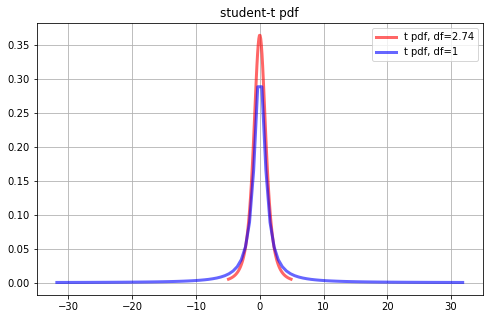

In [3]:
plot_student_t_example()

#### <img src="https://img.icons8.com/office/40/000000/rgb-circle-3.png" style="height:30px;display:inline"> The Gradient of t-SNE
---
* The gradient of the KL-divergence between P and and the Student-t joint-probablity distribution Q is given by $$ \frac{\partial C}{\partial y_i} = 4 \sum_{j \neq i} (p_{ij} - q_{ij})(1 + || y_i - y_j ||^2)^{-1}(y_i - y_j) $$
    * The proof is left for HW, but it uses the same tricks as the gradient for SNE.

* The following shows the gradients between two low-dimensional datapoints $y_i$ and $y_j$ as a function of their pairwise Euclidean distances in the high-dimensional ($||x_i - x_j||$) and low-dimensional ($y_i - y_j$) space: <img src="./assets/tut_xx_tsne_grad.png" style="height:300px"> 

* **Positive** values of the gradient represent an *attraction* between the low-dimensional datapoints $y_i$ and $y_j$.
* **Negative** values of the gradient represent a *repulsion* between the low-dimensional datapoints $y_i$ and $y_j$.
* The advantages of **t-SNE** gradient as seen above:
    * t-SNE's gradient **strongly repels** dissimilar datapoints that are modeled by a small pairwise distance in the low-dimensional represntation. SNE has similar behaviour, but its effect is minimal compared to the strong attractions elsewhere in the gradient.
    * Although t-SNE introduces strong repulsions between dissimilar points that are modeled by small pairwise distances, these repulsions **don't go to infinity**, which makes t-SNE different than UNI-SNE where the strength of the repulsion between very dissimilar datapoints is proportional to their pairwise distance in the low-dimensional map (ehich may cause dissimilar points to move too far away from each other).

#### <img src="https://img.icons8.com/dusk/64/000000/flow-chart.png" style="height:30px;display:inline"> t-SNE Optimization & Algorithm
---
* The optimization of the t-SNE cost function is much easier than the optimization of the cost functions of SNE and UNI-SNE.
* t-SNE introduces long-range forces in the low-dimensional map that can pull back together two clusters of similar points that get separated early on the optimization.

* The algorithm: <img src="./assets/tut_xx_tsne_algo.png" style="height:300px">

* The **momentum** term, $\alpha(t)$, reduces the number of iterations requierd (and works best if it is small until the map points have become moderately well organized).
* The above version can be sped up using *adapative learning scheme*, which gradually increases the learning rate in directions in which the gradient is stable.

* **Tricks** to improve the algorithm:
    * **"Early compression"** - forcing the map points to stay close together at the start of the optimization. When the distances between map points are small, it is easy for clusters to move through one another, which makes it easier to explore the space of possible global organizations of the data.
        * Implementation - adding **L2-penalty** to the cost function that is proportional to the sum of squared distances of map points from the origin.
    * **"Early exaggeration"** - multiplying all of the $p_{ij}$'s by, for example, 4, in the initial stages of the optimization. This means that almost all of the $q_{ij}$'s (which still add up to 1) are still too small to model their corresponding $p_{ij}$'s. This encourages the values of $q_{ij}$'s to become more focused on larger $p_{ij}$'s (i.e., closer points) which as a result causes natural clusters in the data to form tight widely separated clusters in the map (and in the process creating a lot of empty space in the map and allows cluster to move around more easily and find a good global optimization).

#### <img src="https://img.icons8.com/dusk/40/000000/broken-link.png" style="height:30px;display:inline"> t-SNE Weaknesses
---
* **Applying t-SNE to large data sets**
    * t-SNE has a computational and memory complexity that is *quadratic* in the number of datapoints (like many other visualizations techniques).
    * This makes it almost infeasible to apply the standard version of t-SNE to data sets that contain more than 10,000 points.
        * The trivial soultion would be to just use a subset of the data, but this approach does not make use of all the information available.
        * There is a modification to t-SNE that uses random walk on a graph, you can read about it in the official paper (look in the "Credits" section).

* **Dimensionality reduction for other purposes** (other than *visualization*) - it is unclear how t-SNE performs on the more general task of dimensionality reduction (using t-SNE to reduce to $d>3$ dimensions).
    * Because of the heavy tails of the Student-t distribution, it is not enough to look at the behaviour of t-SNE on $d \leq 3$ dimensions. In high-dimensional spaces, the heavy tails comprise a relatively large portion of the probability mass under the Student-t distribution, which may lead to $d$-dimensional data representations that **don't preserve the local structure of the data as well**. In the case of $d>3$, it would be more approriate to use Student-t with more the one degree of freedom.

* **Curse of intrinsic dimensionality** - t-SNE reduces the dimensionality of data mainly based on local properties of the data, which makes t-SNE sensitive to the curse of intrinsic dimensionality of data. In data sets with high intrinsic dimensionality and an underlying manifold that is highly varying, the local linearity assumption on the manifold that t-SNE implicitly makes  (by using Euclidean distances between near neighbors) may be violated.
    * In other words, in complex manifolds, where even the local structure is complex, one cannot assume local linearity. In such cases, deep architectures, like autoencoders, may perform better.

* **Non-convexity of the t-SNE cost function** - unlike other dimensionality reduction techniques such as PCA, Isomap and LLE, t-SNE's cost function is **not convex**, which requiers tuning of the optimization parameters.
    * This fact has important consequence: **t-SNE is non-deterministic**, that is, you can run it multiple times and get a different result each time!

### <img src="https://img.icons8.com/bubbles/50/000000/classroom.png" style="height:50px;display:inline"> Example - The Wisconsin Breast Cancer Dataset
---
We will now see how t-SNE works on the breast cancer dataset, both in 2D and 3D.

In [2]:
# time to see it in action, let's load the breat cancer dataset
dataset = pd.read_csv('./datasets/cancer_dataset.csv', index_col=-1)
# print the number of rows in the data set
number_of_rows = len(dataset)
print('Number of rows in the dataset: {}'.format(number_of_rows))
# separate labels from data
X = dataset.drop(columns=['id', 'diagnosis'])
y = dataset['diagnosis'].values == 'M'
## Show a sample 10 rows
dataset.sample(10)

Number of rows in the dataset: 569


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
NaN,871201,M,19.59,18.15,130.70,1214.0,0.11200,0.16660,0.250800,0.128600,...,26.73,26.39,174.90,2232.0,0.14380,0.38460,0.681000,0.22470,0.3643,0.09223
NaN,901549,B,11.27,12.96,73.16,386.3,0.12370,0.11110,0.079000,0.055500,...,12.84,20.53,84.93,476.1,0.16100,0.24290,0.224700,0.13180,0.3343,0.09215
NaN,859465,B,11.31,19.04,71.80,394.1,0.08139,0.04701,0.037090,0.022300,...,12.33,23.84,78.00,466.7,0.12900,0.09148,0.144400,0.06961,0.2400,0.06641
NaN,89511502,B,12.67,17.30,81.25,489.9,0.10280,0.07664,0.031930,0.021070,...,13.71,21.10,88.70,574.4,0.13840,0.12120,0.102000,0.05602,0.2688,0.06888
NaN,8913,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.022600,0.011710,...,13.62,15.54,87.40,577.0,0.09616,0.11470,0.118600,0.05366,0.2309,0.06915
NaN,906616,B,11.61,16.02,75.46,408.2,0.10880,0.11680,0.070970,0.044970,...,12.64,19.67,81.93,475.7,0.14150,0.21700,0.230200,0.11050,0.2787,0.07427
NaN,8911230,B,11.33,14.16,71.79,396.6,0.09379,0.03872,0.001487,0.003333,...,12.20,18.99,77.37,458.0,0.12590,0.07348,0.004955,0.01111,0.2758,0.06386
NaN,85638502,M,13.17,21.81,85.42,531.5,0.09714,0.10470,0.082590,0.052520,...,16.23,29.89,105.50,740.7,0.15030,0.39040,0.372800,0.16070,0.3693,0.09618
NaN,8912284,B,12.89,15.70,84.08,516.6,0.07818,0.09580,0.111500,0.033900,...,13.90,19.69,92.12,595.6,0.09926,0.23170,0.334400,0.10170,0.1999,0.07127
NaN,884689,B,11.52,14.93,73.87,406.3,0.10130,0.07808,0.043280,0.029290,...,12.65,21.19,80.88,491.8,0.13890,0.15820,0.180400,0.09608,0.2664,0.07809


In [3]:
def plot_tsne(X, dim=2, perplexity=30.0, scale_data=False):
    if dim < 2 or dim > 3:
        print("OH NO :(")
        raise SystemError("2 <= dim <= 3")
    t_sne = TSNE(n_components=dim, perplexity=perplexity)
    if scale_data:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    X_embedded = t_sne.fit_transform(X)
    if dim == 2:
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(1,1,1)
        ax.scatter(X_embedded[y,0], X_embedded[y, 1], color='r', marker='*', label='Malignant')
        ax.scatter(X_embedded[~y,0], X_embedded[~y, 1], color='b', marker='x', label='Benign')
        ax.grid()
        ax.legend()
        ax.set_title("2D t-SNE of the Breast Cancer Dataset")
    else:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
#         ax.axis('equal')
        ax.scatter(X_embedded[y, 0], X_embedded [y, 1], X_embedded [y, 2], color='r', marker='*', label='Malignant')
        ax.scatter(X_embedded[~y, 0], X_embedded [~y, 1], X_embedded [~y, 2], color='b', marker='x', label='Benign')
        ax.grid()
        ax.legend()
        ax.set_title("3D t-SNE of the Breast Cancer Dataset")

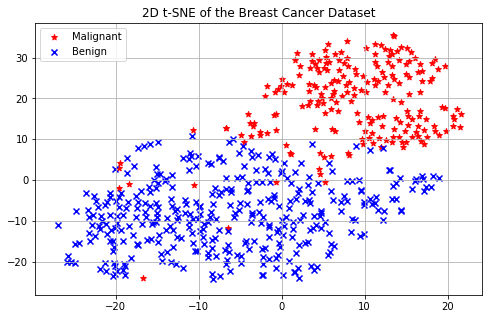

In [4]:
# let's try to reduce to 2 dimensions, with scaling
plot_tsne(X, dim=2, perplexity=30.0, scale_data=True)

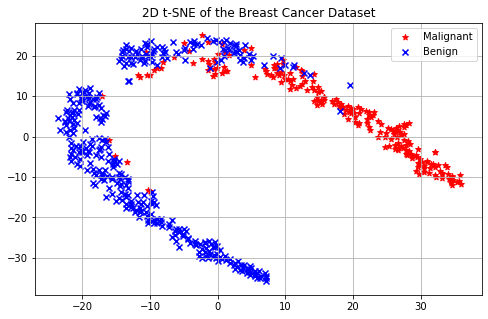

In [5]:
# let's try to reduce to 2 dimensions, without scaling
plot_tsne(X, dim=2, perplexity=30.0, scale_data=False)

<IPython.core.display.Javascript object>


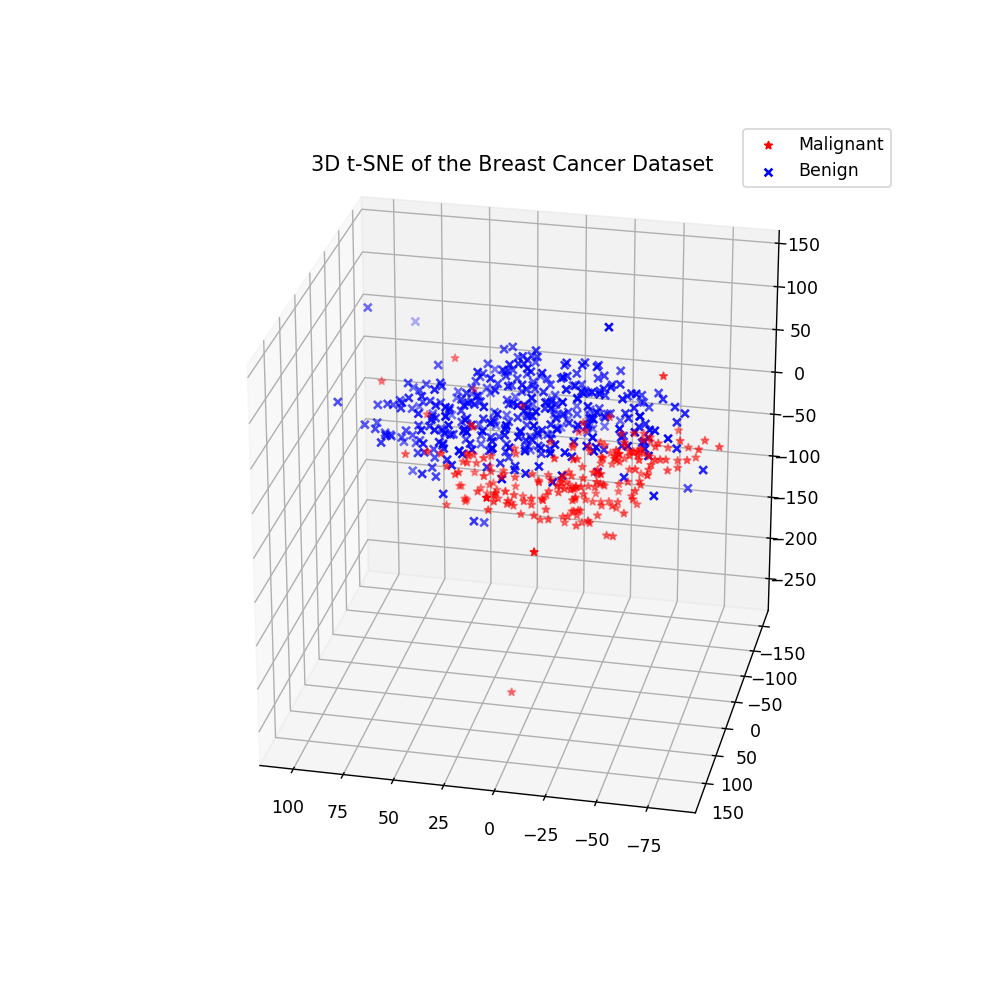

In [7]:
# let's try to reduce to 3 dimensions
%matplotlib notebook
plot_tsne(X, dim=3, perplexity=10.0, scale_data=True)

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Student's T Distribution - <a href="https://www.youtube.com/watch?v=32CuxWdOlow">365 Data Science - Student's T Distribution </a>
* t-SNE - <a href="https://www.youtube.com/watch?v=RJVL80Gg3lA">GoogleTechTalks - Visualizing Data Using t-SNE</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Visualizing Data using t-SNE, der Maaten, Hinton and Bengio - https://lvdmaaten.github.io/tsne/
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/